### Problem’s description
Hanoi is the Capital of Vietnam, and is a leading city that has a significant role in the growth of the country. Because of its dense population and openness to new opportunities, Hanoi is an ideal place for investors, for entrepreneurs to start their businesses or make valuable investments. 
However, from an investor’s perspective, it will be hard to figure out which type of business to open and in which area that business could be attractive to customers and give optimal profit to owner. 
By using Data Science and exploring some geometric data of Hanoi, you can have an overview of the area and understand the general characteristics of different districts in Hanoi. In order to provide investors with this information, it is necessary to answer to some of the questions below 

1.	How many venues in each district? Answering this question gives us a better understanding of the dynamic level of a district.
2.	How many categories in each district? Answering this question helps us know which services the districts offer and how diverse the business operations in these districts are.  
3.	What are the top categories in each district? Based on this question, investors can get a hold of the districts’ characteristics. (E.g: Is it an entertainment center? Is it a food center?)
4.	If we divide the clusters into 3 groups, what can we see about the characteristics of these groups?
5.	If we visualize all information on the map, how does it look like? 


### Data presentation
In order to answer the questions, there is some data that we need to collect.

1.	Information of Hanoi City (HNC)’s districts from Wikipedia. It gives us a list of all main districts of HNC with their area (in Km2), population (in 2017) and the density of each district (people/Km2). Wiki page: https://en.wikipedia.org/wiki/Hanoi 
2.	List of the coordinates (latitude, longitude) of all districts in HNC. This list can be generated from the package geopy.geocoders.Nominatim.
3.	List of average housing prices per m2 in HNC. The list is updated through https:
//mogi.vn/gia-nha-dat. 


### Methodology
1.	First, we need to collect the data by crawling the table of Hanoi’s districts’ information on the wikipedia page and the average housing price on a website. The BeautifulSoup package is used for the scrapping.
2.	The column Density is calculated by dividing Population by area of each district.
3.	Numpy and pandas are the most frequent used packages to manipulate dataframes in this project.
4.	geopy.geocoders.Nominatim is used to get the coordinates of districts and add them to the main data frame.
5.	Folium package is used to visualize the HNC map with its districts. 
6.	Foursquare API is used to explore the venues in each district
7.	K-Means Clustering method is implemented to segment the districts. We then examine the characteristics of each district cluster based on venue observation. 
8.	In order to visualize the charts, seaborn is used.
9.	Package folium is used to visualize the clusters on the map. 





### Crawl data from Wiki

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
# Site URL
url="https://en.wikipedia.org/wiki/Hanoi"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse HTML code for the entire site
soup = BeautifulSoup(html_content, "lxml")
#print(soup.prettify()) # print the parsed data of html


In [3]:
a = soup.find_all("table", class_="wikitable")
print("Number of tables on site: ",len(a))

Number of tables on site:  3


In [4]:
a1 = soup.findAll("table", class_="wikitable")[2]
table_rows = a1.find_all("tr")


In [5]:
head = table_rows[1]
headings = []
for item in head.find_all("th"):
    item = (item.text).rstrip("\n")
    headings.append(item)

In [6]:
headings

['Provincial Cities/Districts[30]',
 'Wards[30]',
 'Area (km2)[30]',
 'Population (2017)[30]']

In [7]:
demographics = []
for tr in table_rows:
    district_demo = tr.find_all("td")
    row_demo = [tr.text for tr in district_demo]
    demographics.append(row_demo)

In [8]:
demographics2 = pd.DataFrame(data=demographics,columns=headings)

In [9]:
demographics3 = demographics2.loc[3:14].rename(columns={"Provincial Cities/Districts[30]":"Provincial Cities/Districts","Wards[30]":"Wards","Area (km2)[30]":"Area (km2)","Population (2017)[30]":"Population (2017)"}).reset_index(drop=True)

In [10]:
demographics3['Population (2017)'] = demographics3['Population (2017)'].str.replace("\n", "").str.strip()

In [11]:
demographics3


,Provincial Cities/Districts,Wards,Area (km2),Population (2017)
0,Ba Đình,14,9.224,"247,100"
1,Bắc Từ Liêm,13,43.35,"333,300"
2,Cầu Giấy,8,12.04,"266,800"
3,Đống Đa,21,9.96,"420,900"
4,Hai Bà Trưng,20,10.09,"318,000"
5,Hà ĐôngHT,17,47.917,"319,800"
6,Hoàn Kiếm,18,5.29,"160,600"
7,Hoàng Mai,14,41.04,"411,500"
8,Long Biên,14,60.38,"291,900"
9,Nam Từ Liêm,10,32.27,"236,700"


In [12]:
demographics3['Area (km2)'] = demographics3['Area (km2)'].apply(lambda x: x.replace('.',''))
demographics3['Population (2017)'] = demographics3['Population (2017)'].apply(lambda x: x.replace(',',''))

In [13]:
demographics3.head()

,Provincial Cities/Districts,Wards,Area (km2),Population (2017)
0,Ba Đình,14,9224,247100
1,Bắc Từ Liêm,13,4335,333300
2,Cầu Giấy,8,1204,266800
3,Đống Đa,21,996,420900
4,Hai Bà Trưng,20,1009,318000


In [14]:
# Add the "Density" column = Population / Area
demographics3["Density (pop/km2)"] = round(demographics3["Population (2017)"].astype(float) / demographics3["Area (km2)"].astype(float), 3)

In [15]:
from unidecode import unidecode
demographics3['Provincial Cities/Districts'] = demographics3['Provincial Cities/Districts'].apply(unidecode).str.strip()

In [16]:
demographics3['Provincial Cities/Districts'] = demographics3['Provincial Cities/Districts'].replace({'Ha DongHT':'Ha Dong'})

**Get housing prices of each district**

In [17]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [18]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.findAll("div", class_="mt-table")[1]

table_rows = table_housing_price.find_all("div", class_="mt-row")
housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol text-right number").span.text
    row = [district, medium_price]
    housing_price.append(row)

In [19]:
housing_price

[['\nQuận Ba Đình\n', '167 triệu/m2'],
 ['\nQuận Cầu Giấy\n', '155 triệu/m2'],
 ['\nQuận Đống Đa\n', '162 triệu/m2'],
 ['\nQuận Hai Bà Trưng\n', '140 triệu/m2'],
 ['\nQuận Hoàn Kiếm\n', '442 triệu/m2'],
 ['\nQuận Hoàng Mai\n', '81,5 triệu/m2'],
 ['\nQuận Long Biên\n', '73,3 triệu/m2'],
 ['\nQuận Tây Hồ\n', '142 triệu/m2'],
 ['\nQuận Thanh Xuân\n', '115 triệu/m2'],
 ['\nQuận Hà Đông\n', '76,8 triệu/m2'],
 ['\nQuận Bắc Từ Liêm\n', '76,8 triệu/m2'],
 ['\nQuận Nam Từ Liêm\n', '85,2 triệu/m2'],
 ['\nHuyện Mê Linh\n', '12 triệu/m2'],
 ['\nHuyện Ba Vì\n', '2,4 triệu/m2'],
 ['\nHuyện Chương Mỹ\n', '10,8 triệu/m2'],
 ['\nHuyện Đan Phượng\n', '23,4 triệu/m2'],
 ['\nHuyện Hoài Đức\n', '40,8 triệu/m2'],
 ['\nHuyện Phúc Thọ\n', '4,8 triệu/m2'],
 ['\nHuyện Quốc Oai\n', '11,1 triệu/m2'],
 ['\nHuyện Thạch Thất\n', '11,4 triệu/m2'],
 ['\nHuyện Thanh Oai\n', '27,1 triệu/m2'],
 ['\nHuyện Thường Tín\n', '23 triệu/m2'],
 ['\nThị Xã Sơn Tây\n', '14,2 triệu/m2'],
 ['\nHuyện Đông Anh\n', '27,2 triệu/m2'],
 ['

In [20]:
house_price2 = pd.DataFrame(housing_price, 
                                columns=["District", "Average Housing Price (1M VND/m2)"])

In [21]:
house_price2 = house_price2.loc[:12].reset_index().drop("index", axis=1)

In [22]:
house_price2

,District,Average Housing Price (1M VND/m2)
0,\nQuận Ba Đình\n,167 triệu/m2
1,\nQuận Cầu Giấy\n,155 triệu/m2
2,\nQuận Đống Đa\n,162 triệu/m2
3,\nQuận Hai Bà Trưng\n,140 triệu/m2
4,\nQuận Hoàn Kiếm\n,442 triệu/m2
5,\nQuận Hoàng Mai\n,"81,5 triệu/m2"
6,\nQuận Long Biên\n,"73,3 triệu/m2"
7,\nQuận Tây Hồ\n,142 triệu/m2
8,\nQuận Thanh Xuân\n,115 triệu/m2
9,\nQuận Hà Đông\n,"76,8 triệu/m2"


In [23]:
# Remove the word "Quận"
house_price2["District"] = house_price2["District"].str.replace("\n", "").str.replace("Quận", "").str.strip()

In [24]:
house_price2

,District,Average Housing Price (1M VND/m2)
0,Ba Đình,167 triệu/m2
1,Cầu Giấy,155 triệu/m2
2,Đống Đa,162 triệu/m2
3,Hai Bà Trưng,140 triệu/m2
4,Hoàn Kiếm,442 triệu/m2
5,Hoàng Mai,"81,5 triệu/m2"
6,Long Biên,"73,3 triệu/m2"
7,Tây Hồ,142 triệu/m2
8,Thanh Xuân,115 triệu/m2
9,Hà Đông,"76,8 triệu/m2"


In [25]:
from unidecode import unidecode
# Remove Vietnamese accents
house_price2["District"] = house_price2["District"].apply(unidecode)

In [26]:
house_price2["Average Housing Price (1M VND/m2)"] = house_price2["Average Housing Price (1M VND/m2)"].str.replace("triệu", "").str.replace(",", ".").str.replace("/m2", "").str.strip()

In [27]:
house_price2

,District,Average Housing Price (1M VND/m2)
0,Ba Dinh,167
1,Cau Giay,155
2,Dong Da,162
3,Hai Ba Trung,140
4,Hoan Kiem,442
5,Hoang Mai,81.5
6,Long Bien,73.3
7,Tay Ho,142
8,Thanh Xuan,115
9,Ha Dong,76.8


**Data merging**

In [28]:
data_hanoi = pd.merge(demographics3, house_price2, how = 'left', right_on = 'District', left_on = 'Provincial Cities/Districts').drop(columns={'District'})

In [29]:
data_hanoi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Provincial Cities/Districts        12 non-null     object 
 1   Wards                              12 non-null     object 
 2   Area (km2)                         12 non-null     object 
 3   Population (2017)                  12 non-null     object 
 4   Density (pop/km2)                  12 non-null     float64
 5   Average Housing Price (1M VND/m2)  12 non-null     object 
dtypes: float64(1), object(5)
memory usage: 672.0+ bytes


In [30]:
data_hanoi.head()

,Provincial Cities/Districts,Wards,Area (km2),Population (2017),Density (pop/km2),Average Housing Price (1M VND/m2)
0,Ba Dinh,14,9224,247100,26.789,167
1,Bac Tu Liem,13,4335,333300,76.886,76.8
2,Cau Giay,8,1204,266800,221.595,155
3,Dong Da,21,996,420900,422.590,162
4,Hai Ba Trung,20,1009,318000,315.164,140


**Get the coordinates of the districts**

In [31]:
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [32]:
def find_coor(name):
#     address = name + "Hanoi City Vietnam"
    geolocator = Nominatim(user_agent="hnc")
    location = geolocator.geocode(name + " hanoi")
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

In [33]:
coords = [find_coor(dist + " District") for dist in data_hanoi["Provincial Cities/Districts"].iloc[:].tolist()]

df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

data_hanoi["Latitude"] = df_coords["Latitude"]
data_hanoi["Longitude"] = df_coords["Longitude"]
data_hanoi


,Provincial Cities/Districts,Wards,Area (km2),Population (2017),Density (pop/km2),Average Housing Price (1M VND/m2),Latitude,Longitude
0,Ba Dinh,14,9224,247100,26.789,167,21.035549,105.824840
1,Bac Tu Liem,13,4335,333300,76.886,76.8,21.069861,105.757339
2,Cau Giay,8,1204,266800,221.595,155,21.027277,105.791464
3,Dong Da,21,996,420900,422.590,162,21.012920,105.827196
4,Hai Ba Trung,20,1009,318000,315.164,140,21.005970,105.857484
5,Ha Dong,17,47917,319800,6.674,76.8,20.952443,105.760955
6,Hoan Kiem,18,529,160600,303.592,442,21.028524,105.850716
7,Hoang Mai,14,4104,411500,100.268,81.5,20.974598,105.863707
8,Long Bien,14,6038,291900,48.344,73.3,21.037154,105.897839
9,Nam Tu Liem,10,3227,236700,73.350,85.2,21.012846,105.760874


**Plot the map of Hanoi city with these districts**

In [34]:
[hn_lat, hn_long] = find_coor("")
print('The geographical coordinates of Hanoi City are {}, {}.'.format(hn_lat, hn_long))

The geographical coordinates of Hanoi City are 21.0294498, 105.8544441.


In [35]:
map_hn = folium.Map(location=[hn_lat, hn_long], zoom_start=12)
for lat, lng, dis in zip(data_hanoi['Latitude'], data_hanoi['Longitude'], data_hanoi['Provincial Cities/Districts']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hn)  

map_hn

**Find out about each district's neighborhood**

In [36]:
CLIENT_ID = '5ODBH5ASCVXDMJBQCFTK31SLJF24KTGO12IOJQZZLX0QDBBT'
CLIENT_SECRET = 'BNV2LP4YSWVNGDXP2E24OXSIMP5W2B1QIXULRV4ZHR000EJO'
VERSION = '20201109'

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
hn_venues = getNearbyVenues(names=data_hanoi['Provincial Cities/Districts'],
                             latitudes=data_hanoi['Latitude'],
                             longitudes=data_hanoi['Longitude']
                            )

In [71]:
hn_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ba Dinh,21.035549,105.82484,Polygon Music,21.029922,105.822862,Rock Club
1,Ba Dinh,21.035549,105.82484,Zennova Massage,21.029979,105.825851,Massage Studio
2,Ba Dinh,21.035549,105.82484,Pizza 4P,21.034181,105.812777,Pizza Place
3,Ba Dinh,21.035549,105.82484,Bia Hơi 19C Ngọc Hà,21.037280,105.831327,Beer Garden
4,Ba Dinh,21.035549,105.82484,Cơm Chay Hà Thành,21.032318,105.825379,Vegetarian / Vegan Restaurant


In [40]:
#Count venues returned for each district
hn_venue_group = hn_venues.groupby('District').count().reset_index()
hn_venue_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ba Dinh,100,100,100,100,100,100
1,Bac Tu Liem,6,6,6,6,6,6
2,Cau Giay,59,59,59,59,59,59
3,Dong Da,77,77,77,77,77,77
4,Ha Dong,8,8,8,8,8,8
5,Hai Ba Trung,82,82,82,82,82,82
6,Hoan Kiem,100,100,100,100,100,100
7,Hoang Mai,4,4,4,4,4,4
8,Long Bien,15,15,15,15,15,15
9,Nam Tu Liem,8,8,8,8,8,8


In [41]:
hn_venue_category_group = hn_venues.groupby('District').agg({'Venue Category':'nunique'}).reset_index()

Text(0.5, 1.0, 'Total Venue Category')

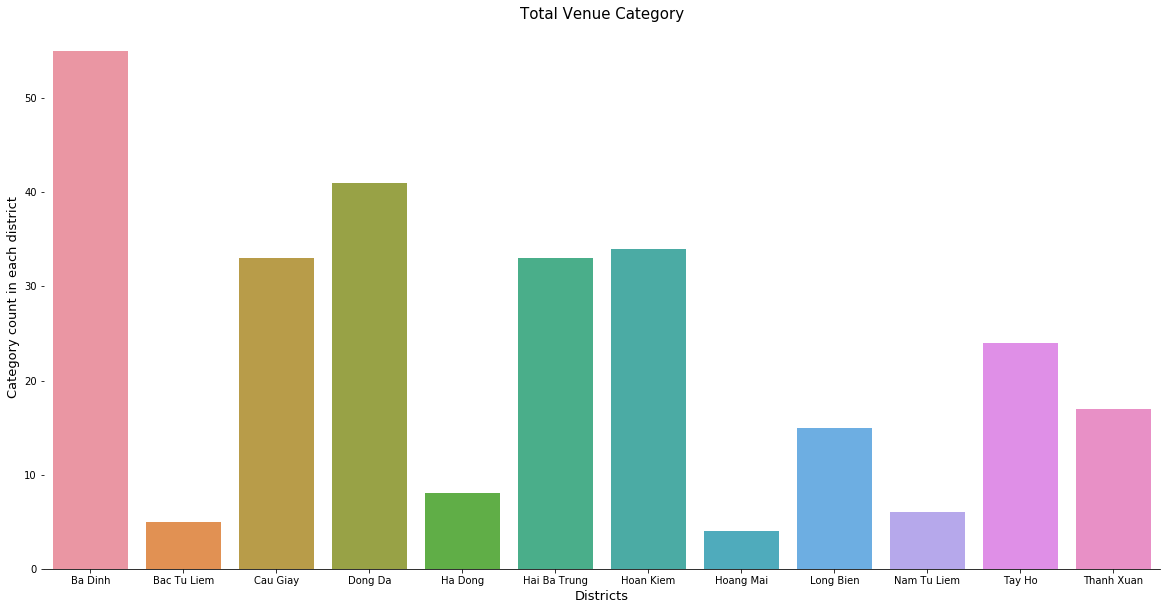

In [42]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(20,10))
sns.barplot(data=hn_venue_category_group,x='District',y='Venue Category')
sns.despine(left=True)
ax.set_xlabel('Districts',fontsize=13)
ax.set_ylabel('Category count in each district',fontsize=13)
ax.set_title('Total Venue Category',fontsize=15)

**Explore data in each district**

Text(0.5, 1.0, 'Total Venue')

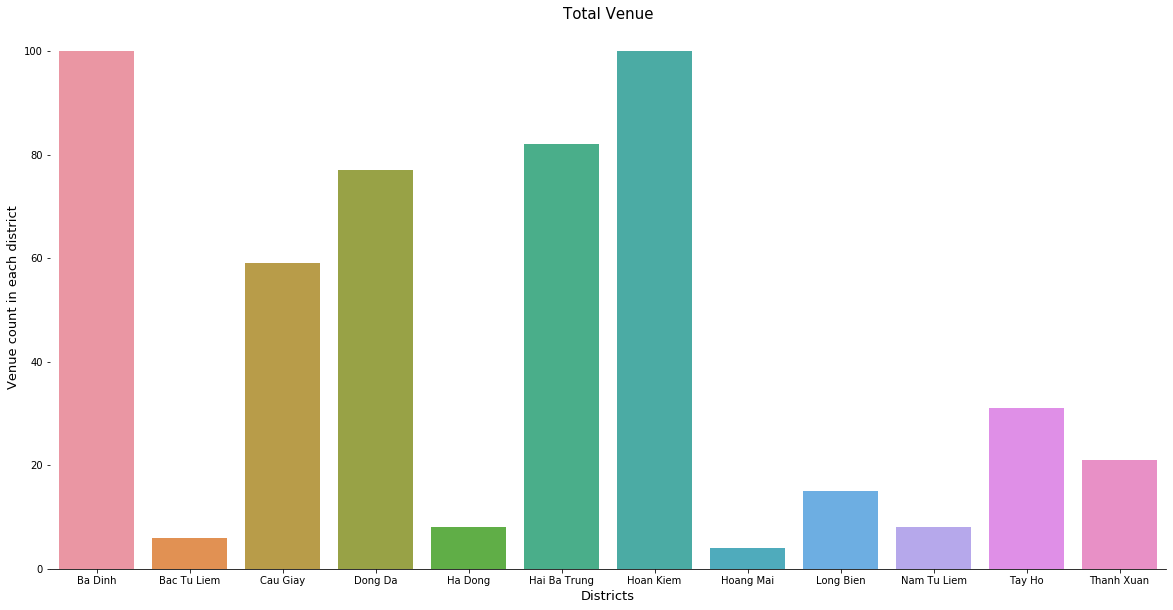

In [43]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(20,10))
sns.barplot(data=hn_venue_group,x='District',y='Venue Category')
sns.despine(left=True)
ax.set_xlabel('Districts',fontsize=13)
ax.set_ylabel('Venue count in each district',fontsize=13)
ax.set_title('Total Venue',fontsize=15)

In [44]:
# one hot encoding
hn_onehot = pd.get_dummies(hn_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hn_onehot['District'] = hn_venues['District'] 

# move district column to the first column
fixed_columns = [hn_onehot.columns[-1]] + list(hn_onehot.columns[:-1])
hn_onehot = hn_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hn_grouped = hn_onehot.groupby('District').mean().reset_index()
hn_grouped.head()

,District,Airport Terminal,Arepa Restaurant,Armenian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Theater,Thrift / Vintage Store,Tiki Bar,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wedding Hall,Wine Bar,Wings Joint
0,Ba Dinh,0.0,0.000000,0.01,0.01,0.0,0.000000,0.0,0.000000,0.010000,...,0.0,0.0,0.000000,0.0,0.01,0.070000,0.0,0.010000,0.01,0.01
1,Bac Tu Liem,0.0,0.000000,0.00,0.00,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.00,0.333333,0.0,0.000000,0.00,0.00
2,Cau Giay,0.0,0.000000,0.00,0.00,0.0,0.016949,0.0,0.016949,0.016949,...,0.0,0.0,0.000000,0.0,0.00,0.118644,0.0,0.016949,0.00,0.00
3,Dong Da,0.0,0.012987,0.00,0.00,0.0,0.012987,0.0,0.012987,0.025974,...,0.0,0.0,0.012987,0.0,0.00,0.077922,0.0,0.000000,0.00,0.00
4,Ha Dong,0.0,0.000000,0.00,0.00,0.0,0.125000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.00,0.00


**Find top 10 categories in each district**

In [45]:
import numpy as np
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hn_10 = pd.DataFrame(columns=columns)
hn_10['District'] = hn_grouped['District']

for ind in np.arange(hn_grouped.shape[0]):
    hn_10.iloc[ind, 1:] = return_most_common_venues(hn_grouped.iloc[ind, :], num_top_venues)

hn_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ba Dinh,Coffee Shop,Café,Hotel,Vietnamese Restaurant,Japanese Restaurant,Pizza Place,Beer Garden,Fried Chicken Joint,Rock Club,Noodle House
1,Bac Tu Liem,Vietnamese Restaurant,Paintball Field,Clothing Store,Bar,Business Service,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant
2,Cau Giay,Vietnamese Restaurant,Coffee Shop,Café,Korean Restaurant,Pizza Place,Hotel,Japanese Restaurant,Fast Food Restaurant,Shopping Mall,Multiplex
3,Dong Da,Coffee Shop,Café,Vietnamese Restaurant,Supermarket,Fast Food Restaurant,Movie Theater,Seafood Restaurant,Beer Garden,Multiplex,BBQ Joint
4,Ha Dong,IT Services,Asian Restaurant,Camera Store,Bus Station,Furniture / Home Store,Gift Shop,Convenience Store,History Museum,Himalayan Restaurant,French Restaurant
5,Hai Ba Trung,Vietnamese Restaurant,Coffee Shop,Noodle House,Japanese Restaurant,Café,Hotel,BBQ Joint,Dessert Shop,Thai Restaurant,Tea Room
6,Hoan Kiem,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café,Spa,Lounge,Italian Restaurant,Hostel,Sandwich Place
7,Hoang Mai,Lake,Soccer Field,Grocery Store,Electronics Store,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,Wings Joint
8,Long Bien,Airport Terminal,Korean Restaurant,Ramen Restaurant,Multiplex,Café,Cafeteria,Shopping Mall,Food Court,Convenience Store,Bowling Alley
9,Nam Tu Liem,Café,Stadium,Golf Course,Athletics & Sports,Gym Pool,Tea Room,Wings Joint,Fast Food Restaurant,French Restaurant,Food Court


In [46]:
hn_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ba Dinh,Coffee Shop,Café,Hotel,Vietnamese Restaurant,Japanese Restaurant,Pizza Place,Beer Garden,Fried Chicken Joint,Rock Club,Noodle House
1,Bac Tu Liem,Vietnamese Restaurant,Paintball Field,Clothing Store,Bar,Business Service,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant
2,Cau Giay,Vietnamese Restaurant,Coffee Shop,Café,Korean Restaurant,Pizza Place,Hotel,Japanese Restaurant,Fast Food Restaurant,Shopping Mall,Multiplex
3,Dong Da,Coffee Shop,Café,Vietnamese Restaurant,Supermarket,Fast Food Restaurant,Movie Theater,Seafood Restaurant,Beer Garden,Multiplex,BBQ Joint
4,Ha Dong,IT Services,Asian Restaurant,Camera Store,Bus Station,Furniture / Home Store,Gift Shop,Convenience Store,History Museum,Himalayan Restaurant,French Restaurant
5,Hai Ba Trung,Vietnamese Restaurant,Coffee Shop,Noodle House,Japanese Restaurant,Café,Hotel,BBQ Joint,Dessert Shop,Thai Restaurant,Tea Room
6,Hoan Kiem,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café,Spa,Lounge,Italian Restaurant,Hostel,Sandwich Place
7,Hoang Mai,Lake,Soccer Field,Grocery Store,Electronics Store,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,Wings Joint
8,Long Bien,Airport Terminal,Korean Restaurant,Ramen Restaurant,Multiplex,Café,Cafeteria,Shopping Mall,Food Court,Convenience Store,Bowling Alley
9,Nam Tu Liem,Café,Stadium,Golf Course,Athletics & Sports,Gym Pool,Tea Room,Wings Joint,Fast Food Restaurant,French Restaurant,Food Court


In [47]:
data_hanoi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Provincial Cities/Districts        12 non-null     object 
 1   Wards                              12 non-null     object 
 2   Area (km2)                         12 non-null     object 
 3   Population (2017)                  12 non-null     object 
 4   Density (pop/km2)                  12 non-null     float64
 5   Average Housing Price (1M VND/m2)  12 non-null     object 
 6   Latitude                           12 non-null     float64
 7   Longitude                          12 non-null     float64
dtypes: float64(3), object(5)
memory usage: 864.0+ bytes


In [48]:
data_hanoi['Average Housing Price (1M VND/m2)'] = data_hanoi['Average Housing Price (1M VND/m2)'].astype(float)

**Merging with housing price in these neighbors**

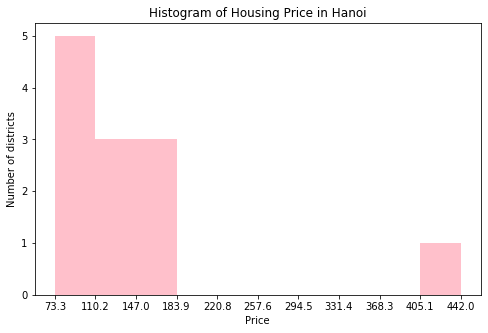

In [49]:
count, bin_edges = np.histogram(data_hanoi['Average Housing Price (1M VND/m2)'])

data_hanoi['Average Housing Price (1M VND/m2)'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, color='pink')

plt.title('Histogram of Housing Price in Hanoi') # add a title to the histogram
plt.ylabel('Number of districts') # add y-label
plt.xlabel('Price') # add x-label

plt.show()

- High price: Price>=186: 2
- Medium price: 110<Price<186: 1
- Low price: Price<=110: 0

In [50]:
def classify_price(price):
    if price <= 110:
        return 0
    elif price <= 186 and price>110:
        return 1
    else:
        return 2

In [51]:
data_hanoi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Provincial Cities/Districts        12 non-null     object 
 1   Wards                              12 non-null     object 
 2   Area (km2)                         12 non-null     object 
 3   Population (2017)                  12 non-null     object 
 4   Density (pop/km2)                  12 non-null     float64
 5   Average Housing Price (1M VND/m2)  12 non-null     float64
 6   Latitude                           12 non-null     float64
 7   Longitude                          12 non-null     float64
dtypes: float64(4), object(4)
memory usage: 864.0+ bytes


In [52]:
data_hanoi['Price evaluation'] = data_hanoi['Average Housing Price (1M VND/m2)'].apply(classify_price)

In [53]:
hn_grouped_cluster =  pd.merge(hn_grouped, data_hanoi[['Density (pop/km2)','Price evaluation','Provincial Cities/Districts']],  left_on = 'District', right_on = 'Provincial Cities/Districts').drop(columns={'Provincial Cities/Districts','District'})

In [72]:
hn_grouped_cluster

,Airport Terminal,Arepa Restaurant,Armenian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,...,Tiki Bar,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wedding Hall,Wine Bar,Wings Joint,Density (pop/km2),Price evaluation
0,0.000000,0.000000,0.01,0.01,0.00,0.000000,0.000,0.000000,0.010000,0.000000,...,0.000000,0.000000,0.01,0.070000,0.000000,0.010000,0.010000,0.01,26.789,1
1,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.333333,0.000000,0.000000,0.000000,0.00,76.886,0
2,0.000000,0.000000,0.00,0.00,0.00,0.016949,0.000,0.016949,0.016949,0.016949,...,0.000000,0.000000,0.00,0.118644,0.000000,0.016949,0.000000,0.00,221.595,1
3,0.000000,0.012987,0.00,0.00,0.00,0.012987,0.000,0.012987,0.025974,0.012987,...,0.012987,0.000000,0.00,0.077922,0.000000,0.000000,0.000000,0.00,422.590,1
4,0.000000,0.000000,0.00,0.00,0.00,0.125000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,6.674,0
5,0.000000,0.012195,0.00,0.00,0.00,0.000000,0.000,0.000000,0.036585,0.012195,...,0.000000,0.000000,0.00,0.219512,0.000000,0.000000,0.000000,0.00,315.164,1
6,0.000000,0.000000,0.00,0.00,0.01,0.010000,0.000,0.000000,0.020000,0.000000,...,0.000000,0.000000,0.02,0.140000,0.000000,0.000000,0.010000,0.00,303.592,2
7,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,100.268,0
8,0.066667,0.000000,0.00,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,48.344,0
9,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.125,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,73.350,0


In [54]:
hn_merge = pd.merge(hn_10,data_hanoi[['Density (pop/km2)','Price evaluation','Provincial Cities/Districts']],  left_on = 'District', right_on = 'Provincial Cities/Districts').drop(columns={'Provincial Cities/Districts'})

In [55]:
hn_merge

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Density (pop/km2),Price evaluation
0,Ba Dinh,Coffee Shop,Café,Hotel,Vietnamese Restaurant,Japanese Restaurant,Pizza Place,Beer Garden,Fried Chicken Joint,Rock Club,Noodle House,26.789,1
1,Bac Tu Liem,Vietnamese Restaurant,Paintball Field,Clothing Store,Bar,Business Service,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,76.886,0
2,Cau Giay,Vietnamese Restaurant,Coffee Shop,Café,Korean Restaurant,Pizza Place,Hotel,Japanese Restaurant,Fast Food Restaurant,Shopping Mall,Multiplex,221.595,1
3,Dong Da,Coffee Shop,Café,Vietnamese Restaurant,Supermarket,Fast Food Restaurant,Movie Theater,Seafood Restaurant,Beer Garden,Multiplex,BBQ Joint,422.590,1
4,Ha Dong,IT Services,Asian Restaurant,Camera Store,Bus Station,Furniture / Home Store,Gift Shop,Convenience Store,History Museum,Himalayan Restaurant,French Restaurant,6.674,0
5,Hai Ba Trung,Vietnamese Restaurant,Coffee Shop,Noodle House,Japanese Restaurant,Café,Hotel,BBQ Joint,Dessert Shop,Thai Restaurant,Tea Room,315.164,1
6,Hoan Kiem,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café,Spa,Lounge,Italian Restaurant,Hostel,Sandwich Place,303.592,2
7,Hoang Mai,Lake,Soccer Field,Grocery Store,Electronics Store,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,Wings Joint,100.268,0
8,Long Bien,Airport Terminal,Korean Restaurant,Ramen Restaurant,Multiplex,Café,Cafeteria,Shopping Mall,Food Court,Convenience Store,Bowling Alley,48.344,0
9,Nam Tu Liem,Café,Stadium,Golf Course,Athletics & Sports,Gym Pool,Tea Room,Wings Joint,Fast Food Restaurant,French Restaurant,Food Court,73.350,0


**Cluster neighbors**
- Using K-mean to group the districts into 3 main neigborhoods 

In [56]:
# set number of clusters
kclusters = 3


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hn_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]

array([2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0])

In [57]:
hn_grouped_cluster

,Airport Terminal,Arepa Restaurant,Armenian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,...,Tiki Bar,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wedding Hall,Wine Bar,Wings Joint,Density (pop/km2),Price evaluation
0,0.000000,0.000000,0.01,0.01,0.00,0.000000,0.000,0.000000,0.010000,0.000000,...,0.000000,0.000000,0.01,0.070000,0.000000,0.010000,0.010000,0.01,26.789,1
1,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.333333,0.000000,0.000000,0.000000,0.00,76.886,0
2,0.000000,0.000000,0.00,0.00,0.00,0.016949,0.000,0.016949,0.016949,0.016949,...,0.000000,0.000000,0.00,0.118644,0.000000,0.016949,0.000000,0.00,221.595,1
3,0.000000,0.012987,0.00,0.00,0.00,0.012987,0.000,0.012987,0.025974,0.012987,...,0.012987,0.000000,0.00,0.077922,0.000000,0.000000,0.000000,0.00,422.590,1
4,0.000000,0.000000,0.00,0.00,0.00,0.125000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,6.674,0
5,0.000000,0.012195,0.00,0.00,0.00,0.000000,0.000,0.000000,0.036585,0.012195,...,0.000000,0.000000,0.00,0.219512,0.000000,0.000000,0.000000,0.00,315.164,1
6,0.000000,0.000000,0.00,0.00,0.01,0.010000,0.000,0.000000,0.020000,0.000000,...,0.000000,0.000000,0.02,0.140000,0.000000,0.000000,0.010000,0.00,303.592,2
7,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,100.268,0
8,0.066667,0.000000,0.00,0.00,0.00,0.000000,0.000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,48.344,0
9,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.125,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,73.350,0


In [58]:
hn_merge

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Density (pop/km2),Price evaluation
0,Ba Dinh,Coffee Shop,Café,Hotel,Vietnamese Restaurant,Japanese Restaurant,Pizza Place,Beer Garden,Fried Chicken Joint,Rock Club,Noodle House,26.789,1
1,Bac Tu Liem,Vietnamese Restaurant,Paintball Field,Clothing Store,Bar,Business Service,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,76.886,0
2,Cau Giay,Vietnamese Restaurant,Coffee Shop,Café,Korean Restaurant,Pizza Place,Hotel,Japanese Restaurant,Fast Food Restaurant,Shopping Mall,Multiplex,221.595,1
3,Dong Da,Coffee Shop,Café,Vietnamese Restaurant,Supermarket,Fast Food Restaurant,Movie Theater,Seafood Restaurant,Beer Garden,Multiplex,BBQ Joint,422.590,1
4,Ha Dong,IT Services,Asian Restaurant,Camera Store,Bus Station,Furniture / Home Store,Gift Shop,Convenience Store,History Museum,Himalayan Restaurant,French Restaurant,6.674,0
5,Hai Ba Trung,Vietnamese Restaurant,Coffee Shop,Noodle House,Japanese Restaurant,Café,Hotel,BBQ Joint,Dessert Shop,Thai Restaurant,Tea Room,315.164,1
6,Hoan Kiem,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café,Spa,Lounge,Italian Restaurant,Hostel,Sandwich Place,303.592,2
7,Hoang Mai,Lake,Soccer Field,Grocery Store,Electronics Store,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,Wings Joint,100.268,0
8,Long Bien,Airport Terminal,Korean Restaurant,Ramen Restaurant,Multiplex,Café,Cafeteria,Shopping Mall,Food Court,Convenience Store,Bowling Alley,48.344,0
9,Nam Tu Liem,Café,Stadium,Golf Course,Athletics & Sports,Gym Pool,Tea Room,Wings Joint,Fast Food Restaurant,French Restaurant,Food Court,73.350,0


In [59]:
hn_merge.insert(0, 'Cluster Labels', kmeans.labels_)

In [60]:
hn_merge2 = pd.merge(hn_merge,data_hanoi[['Provincial Cities/Districts','Latitude','Longitude']], how='left',right_on = 'Provincial Cities/Districts',left_on='District').drop(columns={'Provincial Cities/Districts'})

In [61]:
quintiles = hn_merge2['Density (pop/km2)'].quantile([.2, .25, .3, .35, .4, .5, .6, .7, .8, .9]).to_dict()


In [62]:
def density_level(x):
    if x <= quintiles[.4]:
        return 0
    elif  x > quintiles[.4] and x <= quintiles[.8]:
        return 1
    else:
        return 2

In [63]:
hn_merge2['Density level'] = hn_merge2['Density (pop/km2)'].apply(density_level)

In [64]:
#create map
map_clusters = folium.Map(location=[hn_lat, hn_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        hn_merge2['Latitude'], 
        hn_merge2['Longitude'], 
        hn_merge2['District'], 
        hn_merge2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Examine each cluster group**

In [65]:
cluster_0 = hn_merge2[hn_merge2['Cluster Labels'] == 0]

In [66]:
cluster_0

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Density (pop/km2),Price evaluation,Latitude,Longitude,Density level
2,0,Cau Giay,Vietnamese Restaurant,Coffee Shop,Café,Korean Restaurant,Pizza Place,Hotel,Japanese Restaurant,Fast Food Restaurant,Shopping Mall,Multiplex,221.595,1,21.027277,105.791464,1
3,0,Dong Da,Coffee Shop,Café,Vietnamese Restaurant,Supermarket,Fast Food Restaurant,Movie Theater,Seafood Restaurant,Beer Garden,Multiplex,BBQ Joint,422.590,1,21.012920,105.827196,2
5,0,Hai Ba Trung,Vietnamese Restaurant,Coffee Shop,Noodle House,Japanese Restaurant,Café,Hotel,BBQ Joint,Dessert Shop,Thai Restaurant,Tea Room,315.164,1,21.005970,105.857484,2
6,0,Hoan Kiem,Hotel,Vietnamese Restaurant,Coffee Shop,Noodle House,Café,Spa,Lounge,Italian Restaurant,Hostel,Sandwich Place,303.592,2,21.028524,105.850716,1
11,0,Thanh Xuan,Coffee Shop,Bakery,Café,Multiplex,Buffet,Mobile Phone Shop,Korean Restaurant,Roof Deck,Beer Bar,Shopping Mall,313.282,1,20.993687,105.814301,1


**Comment**
- These districts are the central of entertainment in the city, with a lot of Coffee, Restaurants, or Supermarket, Shopping Mall and Multiplex
- The housing prices are from medium to high in these areas with population density is quite high. 
- Competitiveness in Cafe shop and restaurant is high

In [67]:
cluster_1 = hn_merge2[hn_merge2['Cluster Labels'] == 1]

In [68]:
cluster_1

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Density (pop/km2),Price evaluation,Latitude,Longitude,Density level
10,1,Tay Ho,Café,Vietnamese Restaurant,Noodle House,Pastry Shop,Bakery,Pub,Shopping Mall,Polish Restaurant,Modern European Restaurant,Garden,7012.5,1,21.079042,105.815432,2


**Comment**
- Although the density level is quite high in this area, it seems to be quite refresh as it has garden as its 10th most common venue. 
- It is obviously the central for foreigners as it has a lot of foreign restaurants and also pastry shops

In [69]:
cluster_2 = hn_merge2[hn_merge2['Cluster Labels'] == 2]

In [70]:
cluster_2

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Density (pop/km2),Price evaluation,Latitude,Longitude,Density level
0,2,Ba Dinh,Coffee Shop,Café,Hotel,Vietnamese Restaurant,Japanese Restaurant,Pizza Place,Beer Garden,Fried Chicken Joint,Rock Club,Noodle House,26.789,1,21.035549,105.824840,0
1,2,Bac Tu Liem,Vietnamese Restaurant,Paintball Field,Clothing Store,Bar,Business Service,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,76.886,0,21.069861,105.757339,0
4,2,Ha Dong,IT Services,Asian Restaurant,Camera Store,Bus Station,Furniture / Home Store,Gift Shop,Convenience Store,History Museum,Himalayan Restaurant,French Restaurant,6.674,0,20.952443,105.760955,0
7,2,Hoang Mai,Lake,Soccer Field,Grocery Store,Electronics Store,Escape Room,French Restaurant,Food Court,Fish & Chips Shop,Fast Food Restaurant,Wings Joint,100.268,0,20.974598,105.863707,1
8,2,Long Bien,Airport Terminal,Korean Restaurant,Ramen Restaurant,Multiplex,Café,Cafeteria,Shopping Mall,Food Court,Convenience Store,Bowling Alley,48.344,0,21.037154,105.897839,0
9,2,Nam Tu Liem,Café,Stadium,Golf Course,Athletics & Sports,Gym Pool,Tea Room,Wings Joint,Fast Food Restaurant,French Restaurant,Food Court,73.350,0,21.012846,105.760874,0


**Comment**
- The density level sand the prices in these areas are low, and it seems to be not the central of the city. 
- As the density levels are low and the areas are quite big, these districts are the ideal spots for many outdoor soprt activities such as Paintball Field, Soccer Stadium, Golf Course. Long Bien area is even cultivated for Airport. 